In [41]:
## Import libraries

In [42]:
import torch
from torch import nn
import numpy as np
import os
import random
import torchvision
from torchvision import transforms
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [43]:
seed = 13
torch.manual_seed(seed)

In [44]:
batch_size= 64
lr=0.0002
b1=0.5
b2=0.999
latent_dim=105
n_classes= 5
img_size=32
channels=3

In [45]:
out_dir = "out_img"
try:
    os.makedirs(out_dir)
except OSError:
    pass

In [46]:
transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [47]:
dataset = torchvision.datasets.ImageFolder(root="./Dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers= 7, shuffle=True, drop_last=True, pin_memory=True)

In [48]:
#  Weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [49]:
# compute discriminator accuracy
def discriminator_accuracy(real, fake):
    all = len(real)*2
    real_sum = (real >= 0.5).sum()
    fake_sum = (fake < 0.5).sum()
    correct = real_sum + fake_sum
    percent_corr = correct.item() / all * 100
    return percent_corr

# compute generator accuracy
def generator_accuracy(fake):
    all = len(fake)
    percent_corr = (fake >= 0.5).sum().item() / all * 100
    return percent_corr

### Define Generator

In [50]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        # linear layer
        self.fc = nn.Linear(105, 384)
        # Convolution blocks
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(384, 192, 4, 1, 0, bias=False), # Transposed Convolution
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 48, 4, 2, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(True),
            nn.ConvTranspose2d(48, 3, 4, 2, 1, bias=False),
            nn.Tanh(),        
        )

    def forward(self, input):
        input = input.view(-1, self.latent_dim)
        fc = self.fc(input)
        fc = fc.view(-1, 384, 1, 1)
        out = self.conv_blocks(fc)
        return out


### Define Discriminator

In [51]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        # Convolution blocks
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
            nn.Conv2d(16, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
            nn.Conv2d(32, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Linear(4*4*512, 1), 
            nn.Sigmoid())
        self.aux_layer = nn.Sequential(
            nn.Linear(4*4*512, n_classes), 
            nn.Softmax())

    def forward(self, input):
        convs = self.conv_blocks(input)
        flat6= convs.view(-1, 4*4*512)
        validity = self.adv_layer(flat6).view(-1, 1).squeeze(1)
        label = self.aux_layer(flat6)
        return validity, label

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
# Loss functions
adversarial_loss = torch.nn.BCELoss().to(device)
auxiliary_loss = torch.nn.CrossEntropyLoss().to(device)

# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator(n_classes).to(device)

# Initializing weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

### Training

In [54]:
###### ---------- ######
######  Training  ######
###### ---------- ######
epochs = 150
avg_D_loss, avg_G_loss = 0, 0
loss_Dis, loss_Gen = [], []
loss_Dis_itr, loss_Gen_itr = [], []
D_accuracy_list, G_accuracy_list = [], []
Dis_acc_list, Gen_acc_list = [], []
# correct_d, correct_g = 0 , 0
real_label = 1
fake_label = 0

for epoch in range(epochs):
    for i, (real_imgs, label) in enumerate(dataloader, 0):
        ############ --------------------------------- ################
        # Update discriminator: maximize log(D(x)) + log(1 - D(G(z))) #
        ############ --------------------------------- ################
        
        real_imgs.to(device)
        curr_batch_size = real_imgs.size(0)
        inputs = Variable(torch.FloatTensor(batch_size, 3, img_size, img_size)).to(device)
        noise = Variable(torch.FloatTensor(batch_size, latent_dim, 1, 1)).to(device)
        dis_label = Variable(torch.FloatTensor(batch_size)).to(device)
        aux_label = Variable(torch.LongTensor(batch_size)).to(device)              
        dis_label.data.resize_(curr_batch_size).fill_(real_label)
        aux_label.data.resize_(curr_batch_size).copy_(label)
        
        # ------------------------ #
        #  Training Discriminator  #
        # ------------------------ #

        discriminator.zero_grad()
        inputs.data.resize_as_(real_imgs).copy_(real_imgs)
        dis_output_real, pred_label_real = discriminator(inputs) # real img
        # Loss for real images
        D_real_loss = adversarial_loss(dis_output_real, dis_label) + auxiliary_loss(pred_label_real, aux_label)
        D_real_loss.backward()
        
        # compute discriminator accuracy
        preds_ = pred_label_real.data.max(1)[1]
        correct = preds_.eq(aux_label.data).cpu().sum()
        D_accuracy = float(correct) / float(len(aux_label.data)) * 100.0
        
        # train with fake
        noise.data.resize_(curr_batch_size, latent_dim, 1, 1).normal_(0, 1)
        label = np.random.randint(0, n_classes, curr_batch_size)
        noise_ = np.random.normal(0, 1, (curr_batch_size, latent_dim))
        onehot_classes = np.zeros((curr_batch_size, n_classes))
        onehot_classes[np.arange(curr_batch_size), label] = 1
        noise_[np.arange(curr_batch_size), :n_classes] = onehot_classes[np.arange(curr_batch_size)]
        noise_ = (torch.from_numpy(noise_))
        noise.data.copy_(noise_.view(curr_batch_size, latent_dim, 1, 1))
        aux_label.data.resize_(curr_batch_size).copy_(torch.from_numpy(label))
        fake_imgs = generator(noise)
        # Loss for fake images
        dis_label.data.fill_(fake_label)
        dis_output_fake, pred_label_fake = discriminator(fake_imgs.detach()) # fake img
        # d_fake_loss
        D_fake_loss = adversarial_loss(dis_output_fake, dis_label) + auxiliary_loss(pred_label_fake, aux_label)
        D_fake_loss.backward()
        d_loss = D_real_loss + D_fake_loss
        optimizer_D.step()

        # compute generator accuracy
        preds_ = pred_label_fake.data.max(1)[1].cpu()
        correct = preds_.eq(torch.Tensor(label).data).cpu().sum()
        G_accuracy = float(correct) / float(len(label.data)) * 100.0
        
        ############ ------------- ################
        # Update Generator: maximize log(D(G(z))) #
        ############ ------------- ################
        
        # -------------------- #
        #  Training Generator  #
        # -------------------- #
        generator.zero_grad()
        dis_label.data.fill_(real_label)  # fake labels are real for generator cost
        dis_output, pred_label = discriminator(fake_imgs)
        g_loss = adversarial_loss(dis_output, dis_label) + auxiliary_loss(pred_label, aux_label)
        g_loss.backward()
        optimizer_G.step()
        
        Dis_acc = discriminator_accuracy(dis_output_real, dis_output_fake)
        Gen_acc = generator_accuracy(dis_output)
        
        # compute the average loss
        curr_iter = epoch * len(dataloader) + i
        sum_G_loss = avg_G_loss * curr_iter
        sum_D_loss = avg_D_loss * curr_iter
        sum_G_loss += g_loss.item()
        sum_D_loss += d_loss.item()
        avg_G_loss = sum_G_loss / (curr_iter + 1)
        avg_D_loss = sum_D_loss / (curr_iter + 1)

        loss_Dis.append(avg_D_loss)
        loss_Gen.append(avg_G_loss)
        
        loss_Dis_itr.append(d_loss.item())
        loss_Gen_itr.append(g_loss.item())
        
        D_accuracy_list.append(D_accuracy)
        G_accuracy_list.append(G_accuracy)
        
        Dis_acc_list.append(Dis_acc)
        Gen_acc_list.append(Gen_acc)

        if i % 5 == 0:
            print('[Epoch: %d/%d][Batch: %d/%d] [D_Loss: %.4f, D_Acc: %.3f%%] [G_Loss: %.4f]'
                % (epoch+1, epochs, i+1, len(dataloader),
                    avg_D_loss, D_accuracy, avg_G_loss))
            
        eval_noise = Variable(torch.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)).to(device)
        eval_noise_ = np.random.normal(0, 1, (batch_size, latent_dim))
        eval_label = np.random.randint(0, n_classes, batch_size)
        eval_onehot = np.zeros((batch_size, n_classes))
        eval_onehot[np.arange(batch_size), eval_label] = 1
        eval_noise_[np.arange(batch_size), :n_classes] = eval_onehot[np.arange(batch_size)]
        eval_noise_ = (torch.from_numpy(eval_noise_))
        eval_noise.data.copy_(eval_noise_.view(batch_size, latent_dim, 1, 1))
        
        if i == len(dataloader) - 1:
            save_image(
                real_imgs, '%s/real_img.png' % out_dir)
            fake = generator(eval_noise)
            save_image(
                fake.data,
                '%s/fake_epoch%02d.png' % (out_dir, epoch)
            )

[Epoch: 1/150][Batch: 1/15] [D_Loss: 4.7433, D_Acc: 12.500%] [G_Loss: 2.3489]
[Epoch: 1/150][Batch: 6/15] [D_Loss: 4.5509, D_Acc: 23.438%] [G_Loss: 2.4297]
[Epoch: 1/150][Batch: 11/15] [D_Loss: 4.4420, D_Acc: 29.688%] [G_Loss: 2.4953]
[Epoch: 2/150][Batch: 1/15] [D_Loss: 4.3185, D_Acc: 31.250%] [G_Loss: 2.6312]
[Epoch: 2/150][Batch: 6/15] [D_Loss: 4.2590, D_Acc: 34.375%] [G_Loss: 2.7222]
[Epoch: 2/150][Batch: 11/15] [D_Loss: 4.2691, D_Acc: 54.688%] [G_Loss: 2.7759]
[Epoch: 3/150][Batch: 1/15] [D_Loss: 4.2430, D_Acc: 54.688%] [G_Loss: 2.8310]
[Epoch: 3/150][Batch: 6/15] [D_Loss: 4.2312, D_Acc: 42.188%] [G_Loss: 2.8539]
[Epoch: 3/150][Batch: 11/15] [D_Loss: 4.2142, D_Acc: 53.125%] [G_Loss: 2.8777]
[Epoch: 4/150][Batch: 1/15] [D_Loss: 4.2010, D_Acc: 48.438%] [G_Loss: 2.9025]
[Epoch: 4/150][Batch: 6/15] [D_Loss: 4.2025, D_Acc: 56.250%] [G_Loss: 2.9103]
[Epoch: 4/150][Batch: 11/15] [D_Loss: 4.1998, D_Acc: 51.562%] [G_Loss: 2.9326]
[Epoch: 5/150][Batch: 1/15] [D_Loss: 4.1924, D_Acc: 53.125%]

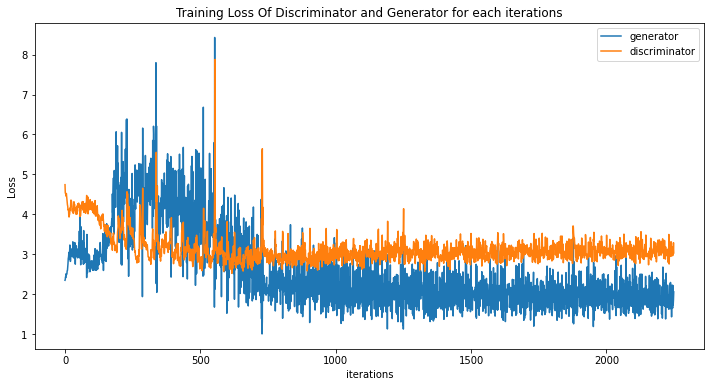

In [59]:
plt.figure(figsize=(12,6))
plt.plot(loss_Gen_itr,label="generator")
plt.plot(loss_Dis_itr,label="discriminator")
plt.title("Training Loss Of Discriminator and Generator for each iterations")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

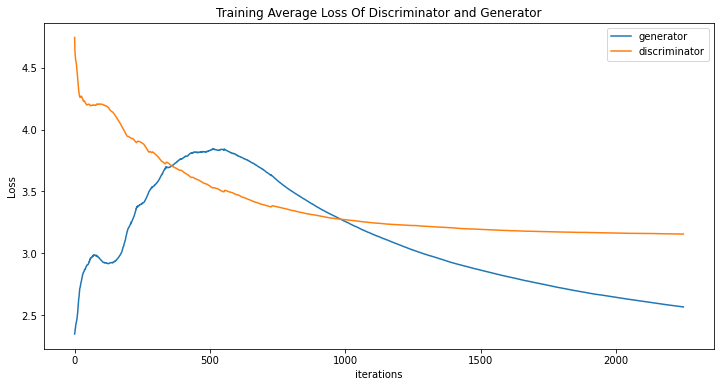

In [56]:
plt.figure(figsize=(12,6))
plt.plot(loss_Gen,label="generator")
plt.plot(loss_Dis,label="discriminator")
plt.title("Training Average Loss Of Discriminator and Generator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

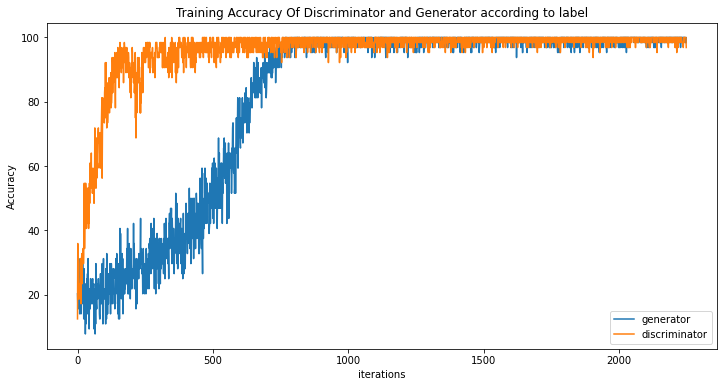

In [57]:
plt.figure(figsize=(12,6))
plt.plot(G_accuracy_list,label="generator")
plt.plot(D_accuracy_list,label="discriminator")
plt.title("Training Accuracy Of Discriminator and Generator according to label")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

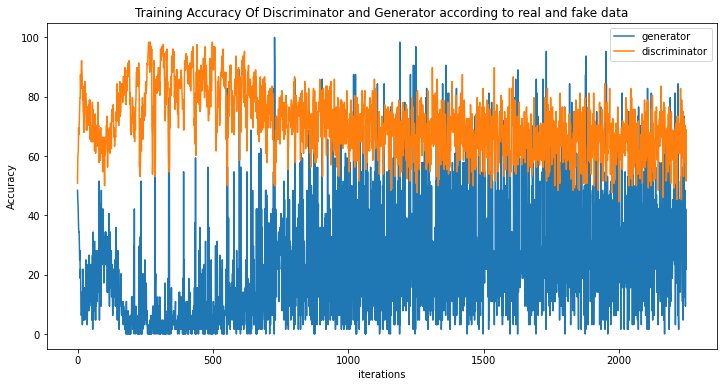

In [58]:
plt.figure(figsize=(12,6))
plt.plot(Gen_acc_list,label="generator")
plt.plot(Dis_acc_list,label="discriminator")
plt.title("Training Accuracy Of Discriminator and Generator according to real and fake data")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()